## Техническое описание класса UCB:

**Функциональность:**

1. **Взаимодействие с LLM:**
    - Класс `BaseAgent` инкапсулирует логику взаимодействия с LLM (конкретно, моделью `gpt-4o-mini` через OpenAI API). 
    - Он принимает системный промпт при инициализации и предоставляет метод `__call__` для отправки сообщений модели и получения ответов.

2. **Оптимизация промпта:**
    - Класс `PromptOptimizer` отвечает за оптимизацию промпта, используя экземпляр `BaseAgent` для связи с LLM. 
    - Он принимает на вход:
        -  исходный промпт, 
        -  параметры оптимизации (количество итераций, размер пучка для Монте-Карло, параметры градиентного спуска, критерии оценки в формате JSON).

3. **Генерация кандидатов (`generate_candidates`)**:
    - Создает список потенциально улучшенных промптов на основе текущего, используя два подхода:
        - **Метод Монте-Карло (`generate_monte_carlo_candidate`)**: Генерирует перефразированные версии промпта, запрашивая у LLM "перефразировать, сохраняя смысл".
        - **Градиентный спуск (`generate_gradient_candidate`)**: 
            - Получает ответ LLM на текущий промпт.
            - Вызывает `generate_gradient()` для анализа ответа и получения текстового описания потенциальных улучшений (градиента).
            - Запрашивает у LLM несколько (`steps_per_gradient`) улучшенных вариантов промпта, основываясь на сгенерированном градиенте.

4. **Оценка кандидатов (`evaluate_candidates`)**:
    - Оценивает каждый сгенерированный промпт-кандидат, вызывая `evaluate_response()` и возвращая список оценок.

5. **Оценка ответа (`evaluate_response`)**:
    - **Ключевая функция, определяющая качество ответа LLM на данный промпт.**
    - Анализирует ответ на соответствие критериям, заданным в `evaluation_criteria`:
        - Для каждого критерия вызывает `check_criterion()`, чтобы проверить, выполняется ли условие.
        - Начисляет или снимает баллы в зависимости от важности (`weight`) и обязательности (`required`) критерия.
    - Дополнительно рассчитывает метрики ROUGE и BLEU, сравнивая ответ с исходным промптом, и включает их в общую оценку с заданными весами.
    - Возвращает нормализованную оценку в диапазоне [-1, 1].

6. **Проверка критерия (`check_criterion`)**:
    - Принимает на вход ответ LLM и строку `criterion_check`, содержащую код Python для проверки.
    - Выполняет этот код, передавая `response` как контекст, что позволяет задавать **произвольные критерии оценки** на языке Python.
    - Возвращает True, если условие выполнено, и False в противном случае.

7. **Выбор лучшего кандидата (`select_best_candidate`)**:
    - Использует алгоритм UCB для выбора наилучшего кандидата из списка, балансируя между исследованием новых кандидатов и эксплуатацией уже известных хороших.
    - Учитывает не только среднюю оценку кандидата, но и дисперсию оценок, что позволяет делать более обоснованный выбор в условиях неопределенности.

8. **Генерация градиента (`generate_gradient`)**:
    - **Функция, автоматизирующая процесс определения критериев оценки и генерации градиента для улучшения промпта.**
    - Отправляет LLM запрос с текущим промптом и просьбой:
        - Определить наиболее важные критерии оценки для этого промпта.
        - Сгенерировать для каждого критерия текстовое описание возможных улучшений (градиент).
    - Ожидает ответ в строго определенном формате JSON, содержащем список критериев с их описанием, важностью, обязательностью и кодом проверки.
    - Анализирует ответ LLM на соответствие сгенерированным критериям.
    - Формирует итоговый текстовый градиент, перечисляя невыполненные критерии и предлагаемые LLM улучшения.

**Механизмы:**

- **Метод Монте-Карло:** Используется для стохастического поиска в пространстве промптов, генерируя случайные вариации.
- **Градиентный спуск:**  Направляет поиск в сторону улучшения промпта, основываясь на анализе ответов LLM и сгенерированных градиентах.
- **Алгоритм UCB:**  Обеспечивает баланс между исследованием новых кандидатов и использованием уже известных хороших, ускоряя сходимость оптимизации.
- **Динамическая генерация критериев оценки:** Делегирует LLM задачу определения критериев оценки, адаптируя процесс оптимизации к конкретным промптам и задачам.
- **Метрики ROUGE и BLEU:** Используются для оценки качества сгенерированного текста путем сравнения его с исходным промптом. ROUGE измеряет степень перекрытия n-грамм между текстами, а BLEU оценивает точность перевода, сравнивая сгенерированный текст с несколькими референтными переводами. 



---

### **Математическая формализация и пояснение механизмов**

#### **Метод Монте-Карло**

#### **Определение**

**Метод Монте-Карло** — это стохастический метод, который использует случайные выборки для моделирования и решения математических и физических задач. В контексте поиска в пространстве промптов, метод Монте-Карло генерирует случайные вариации промптов и оценивает их эффективность с целью нахождения оптимального или приближенного решения.

#### **Механизм работы алгоритма**

Процесс метода Монте-Карло можно разделить на несколько основных шагов:

1. **Генерация случайных промптов.** В этом шаге случайно выбираются или варьируются параметры, которые влияют на формирование промпта.
2. **Оценка промптов.** Каждый сгенерированный промпт оценивается по заранее определенным метрикам или критериям (например, по качеству сгенерированного текста).
3. **Агрегация результатов.** На основе множества испытаний рассчитывается средняя или интегральная метрика, характеризующая эффективность определенных параметров.
4. **Анализ результатов.** Изучение распределения результатов позволяет сделать выводы о том, какие параметры или их комбинации работают лучше всего.

#### **Математическая формализация**

Предположим, что мы оцениваем функцию $f(x)$ на основе случайных выборок $x_1, x_2, \dots, x_N$, которые следуют определенному распределению вероятностей $P(x)$. Оценка ожидаемого значения $E[f(x)]$ функции $f(x)$ с помощью метода Монте-Карло вычисляется как:

$$E[f(x)] \approx \frac{1}{N} \sum_{i=1}^{N} f(x_i)$$

где $N$ — количество случайных выборок.

#### **Вывод**

Метод Монте-Карло — это мощный и гибкий инструмент, который может быть использован для решения задач оптимизации в случаях, когда аналитическое решение невозможно или трудно найти. В контексте генерации и оптимизации промптов этот метод помогает находить лучшие вариации за счет случайного исследования пространства возможных решений.

---

#### **Алгоритм UCB**

#### **Определение**

**Upper Confidence Bound (UCB)** — это алгоритм, предназначенный для решения задачи многорукого бандита, который балансирует между исследованием новых вариантов (exploration) и использованием известных хороших вариантов (exploitation). В контексте оптимизации промптов, UCB позволяет ускорить процесс нахождения оптимального промпта, обеспечивая быстрый переход от исследования новых вариантов к использованию найденных эффективных решений.

#### **Механизм работы алгоритма**

Алгоритм UCB работает следующим образом:

1. **Инициализация.** В начале каждому промпту присваивается начальное значение оценки.
2. **Выбор промпта.** Для каждого промпта рассчитывается доверительный интервал, и выбирается тот, у которого верхняя граница доверительного интервала (Upper Confidence Bound) максимальна.
3. **Обновление оценки.** После выбора и оценки промпта, его значение обновляется на основе полученного результата.
4. **Повторение процесса.** Шаги 2 и 3 повторяются до достижения сходимости, при этом со временем алгоритм все больше использует наиболее успешные промпты.

#### **Математическая формализация**

Для каждого промпта $i$ на шаге $t$ UCB рассчитывается следующим образом:

$$a_i(t) = \bar{x}_i(t) + c \sqrt{\frac{2 \ln t}{n_i(t)}}$$

где:
- $\bar{x}_i(t)$ — среднее значение награды для промпта $i$ до момента $t$,
- $n_i(t)$ — количество раз, когда промпт $i$ был выбран до момента $t$,
- $c$ — параметр, регулирующий степень исследования (exploration),
- $t$ — текущее количество шагов.

#### **Вывод**

Алгоритм UCB эффективно балансирует между исследованием новых вариантов и использованием известных успешных вариантов. В задачах оптимизации промптов UCB может существенно сократить время, необходимое для нахождения оптимального решения, благодаря своим адаптивным свойствам.

---

#### **Метрики ROUGE и BLEU**

#### **Определение**

**ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) и **BLEU** (Bilingual Evaluation Understudy) — это метрики, используемые для оценки качества текста, сгенерированного алгоритмами на основе исходного текста (референсного промпта). ROUGE измеряет степень перекрытия n-грамм между сгенерированным текстом и референсом, в то время как BLEU оценивает точность перевода, сравнивая сгенерированный текст с одним или несколькими референтными переводами.

#### **Механизм работы алгоритма**

#### **ROUGE**
1. **Разбиение текста на n-граммы.** Оба текста (сгенерированный и референсный) разбиваются на n-граммы — последовательности из n слов.
2. **Подсчет совпадений.** Подсчитывается количество совпадений n-грамм между двумя текстами.
3. **Оценка перекрытия.** Рассчитываются различные метрики, такие как ROUGE-N, ROUGE-L, которые отражают степень перекрытия n-грамм, длины последовательностей слов и т.д.

#### **BLEU**
1. **Разбиение текста на n-граммы.** Текст и референсный перевод разбиваются на n-граммы.
2. **Подсчет совпадений.** Подсчитывается количество совпадений n-грамм между сгенерированным текстом и каждым референсным переводом.
3. **Корректировка длины.** Вводится штраф за длину, чтобы учитывать, что слишком короткий текст может получить высокую оценку за совпадение n-грамм, но не быть точным переводом.
4. **Сводка результатов.** Вычисляется среднее значение точности для всех n-грамм с учетом штрафа за длину.

#### **Математическая формализация**

#### **ROUGE-N**
Метрика ROUGE-N для n-грамм вычисляется как:

$$\text{ROUGE-N} = \frac{\sum_{s \in \text{ref}} \sum_{n\text{-gram} \in s} \min(\text{Count}_\text{match}(n\text{-gram}), \text{Count}_\text{gen}(n\text{-gram}))}{\sum_{s \in \text{ref}} \sum_{n\text{-gram} \in s} \text{Count}_\text{ref}(n\text{-gram})}$$

#### **BLEU**
Метрика BLEU вычисляется как:

$$\text{BLEU} = BP \cdot \exp \left( \sum_{n=1}^{N} w_n \log p_n \right)$$

где:
- $BP$ — штраф за длину (brevity penalty),
- $p_n$ — точность для n-грамм,
- $w_n$ — весовая коэффициента для n-грамм.

#### **Вывод**

Метрики ROUGE и BLEU являются стандартными инструментами для оценки качества сгенерированного текста в задачах обработки естественного языка. ROUGE подчеркивает степень покрытия текстовых сегментов, а BLEU — точность и адекватность перевода. Эти метрики помогают объективно оценивать, насколько сгенерированный текст соответствует ожиданиям на основе исходных данных.


In [9]:
# ============================
# БЛОК ИМПОРТОВ
# ============================

# Импорт стандартных библиотек
import json
import random

# Импорт внешних библиотек
import numpy as np
import openai
import rouge
import sacrebleu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

# Импорт библиотеки для загрузки переменных окружения из файла .env
from dotenv import load_dotenv

# Импорт библиотек LangChain
from langsmith import traceable
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage

# Импорт внутренних библиотек
from back.file_manager import FileManager

import random
import numpy as np
from collections import namedtuple

from sklearn.manifold import TSNE
import networkx as nx
import plotly.graph_objs as go

---
### Chat-GPT

In [10]:
class BaseAgent:
    """
    Description:
        Класс для взаимодействия с LLM через OpenAI API.

    Attributes:
        system_prompt: Начальный системный промпт для модели.
    """
    def __init__(self, system_prompt: str):
        """
        Description:
            Инициализация класса BaseAgent.

        Args:
            system_prompt: Начальный системный промпт для модели.
        """
        self.system_prompt = system_prompt

    @traceable(run_type="llm")
    def __call__(self, messages: list) -> str:
        """
        Description:
            Выполнение вызова к LLM с заданными сообщениями.

        Args:
            messages: Список сообщений для отправки в LLM.

        Returns:
            Ответ модели в виде строки.
        """
        response = openai.chat.completions.create(
            model="gpt-4o-mini", 
            messages=[
                {"role": "system", 
                 "content": self.system_prompt},
                *messages
            ]
        ).choices[0].message.content
        return response

---
### TGI - Llama 3.1 70B

In [11]:
# class BaseAgent:
#     """
#     Description:
#         Класс для взаимодействия с моделью ChatOpenAI.
#     """
    
#     def __init__(self, system_prompt: str):
#         """
#         Description:
#             Инициализирует экземпляр CustomChatModel.
            
#         Args:
#             system_prompt: Начальный системный промпт для модели.
#         """
#         self.system_prompt = system_prompt
        
#         self.client = ChatOpenAI(
#             base_url=os.getenv("TGI_URL"),
#             api_key="-",
#             model=os.getenv("MODEL_NAME"),
#             temperature=0.1,
#             n=10,
#             top_p=0.9,
#             max_tokens=4096,
#             streaming=False,
#             verbose=True,
#         )
    
#     def __call__(self, messages: List[BaseMessage]) -> str:
#         """
#         Description:
#             Генерирует ответ от модели на основе предоставленных сообщений.

#         Args:
#             messages (List[BaseMessage]): Список сообщений для отправки модели.

#         Returns:
#             str: Ответ от модели в виде строки.
#         """
#         messages = [
#             SystemMessage(content = self.system_prompt),
#             HumanMessage(content = messages)
#         ]
        
#         # Вызов API
#         response = self.client.invoke(messages)
        
#         return response.content

In [12]:
class UCB:
    """
    Description:
        Класс для оптимизации промпта с использованием методов Монте-Карло и градиентного спуска.
        Теперь включает методы для визуализации эмбендингов.
    """
    def __init__(self,
                 llm: BaseAgent,
                 initial_prompt: str,
                 num_iterations: int = 1,
                 beam_size: int = 4,
                 steps_per_gradient: int = 2,
                 evaluation_criteria: str = '{}'):
        """
        Description:
            Инициализация класса PromptOptimizer.

        Args:
            llm: Экземпляр класса BaseAgent для взаимодействия с LLM.
            initial_prompt: Исходный промпт для оптимизации.
            num_iterations: Количество итераций оптимизации.
            beam_size: Размер выборки для поиска лучшего кандидата.
            steps_per_gradient: Количество шагов на градиент.
            evaluation_criteria: Конфигурация для оценки ответов модели в формате JSON.
        """
        self.llm = llm
        self.prompt = initial_prompt
        self.num_iterations = num_iterations
        self.beam_size = beam_size
        self.steps_per_gradient = steps_per_gradient
        self.evaluation_criteria = json.loads(evaluation_criteria)
        self.embeddings = OpenAIEmbeddings()

    def optimize(self) -> str:
        """
        Description:
            Основной метод оптимизации промпта.

        Returns:
            Оптимизированный промпт.
        """
        for i in range(self.num_iterations):
            print(f"[INFO] === Iteration {i+1}/{self.num_iterations} ===")
            # Генерируем кандидатов на основе текущего промпта
            candidates = self.generate_candidates()
            # Оцениваем каждого кандидата
            candidate_scores = self.evaluate_candidates(candidates, self.evaluation_criteria)
            # Выбираем лучшего кандидата по результатам оценки
            best_candidate_idx = self.select_best_candidate(candidate_scores)
            # Обновляем текущий промпт лучшим кандидатом
            self.prompt = candidates[best_candidate_idx]
            print(f"[INFO] Best prompt at iteration {i+1}: {self.prompt}\n")
            
            # Визуализируем эмбендинги кандидатов
            self.visualize_embeddings(candidates)

        return self.prompt

    def generate_candidates(self) -> list:
        """
        Description:
            Генерация списка кандидатов на основе исходного промпта.

        Returns:
            Список сгенерированных кандидатов.
        """
        candidates = [self.prompt]
        
        # Генерация кандидатов с использованием метода Монте-Карло
        for _ in range(self.beam_size):
            monte_carlo_candidate = self.generate_monte_carlo_candidate(self.prompt)
            candidates.append(monte_carlo_candidate)
        
        # Генерация кандидатов на основе градиентного спуска
        for _ in range(self.beam_size):
            gradient_candidate = self.generate_gradient_candidate(self.prompt)
            candidates.append(gradient_candidate)
        
        return candidates

    def generate_monte_carlo_candidate(self, prompt: str) -> str:
        """
        Description:
            Генерация кандидата с использованием метода Монте-Карло.

        Args:
            prompt: Исходный промпт.

        Returns:
            Сгенерированный промпт.
        """
        paraphrased_prompt = self.llm(messages=[{"role": "user", "content": f"Перефразируй следующий текст, сохраняя смысл:\n{prompt}"}])
        return paraphrased_prompt

    def generate_gradient_candidate(self, prompt: str) -> str:
        """
        Description:
            Генерация кандидата с использованием адаптивного градиентного подхода, учитывающего историю изменений.

        Args:
            prompt: Исходный промпт.

        Returns:
            Сгенерированный промпт с улучшениями.
        """
        # Получаем ответ от LLM на исходный промпт
        response = self.llm(messages=[{"role": "user", "content": prompt}])

        # Генерируем текстовые улучшения на основе анализа ответа LLM
        gradient = self.generate_gradient(prompt, response)

        # Запрашиваем у LLM улучшенные версии промпта на основе предложенных улучшений
        improved_prompt = self.llm(messages=[{"role": "user", "content": f"""
            <task>
                <goal>Оптимизировать текущий промпт для ИИ-помощника.</goal>
                <input>
                    <current_prompt>{prompt}</current_prompt>
                    <history_of_changes>{gradient}</history_of_changes>
                </input>
                <requirements>
                    <step_count>{self.steps_per_gradient}</step_count>
                    <adaptiveness>Повышенная адаптивность с каждым шагом улучшений.</adaptiveness>
                    <quality>Каждая версия должна быть лучше предыдущей, учитывать изменения и улучшаться по градиенту.</quality>
                </requirements>
                <output>
                    <improved_prompts>Список улучшенных версий промпта.</improved_prompts>
                </output>
            </task>
            <examples>
                <example_1>Версия промпта с добавленным контекстом.</example_1>
                <example_2>Версия промпта с улучшенной структурой.</example_2>
            </examples>
            """}])
        
        return improved_prompt

    def evaluate_candidates(self, candidates: list, evaluation_criteria: dict) -> list:
        """
        Description:
            Оценка кандидатов на основе заданных критериев.

        Args:
            candidates: Список кандидатов.
            evaluation_criteria: Словарь с критериями оценки.

        Returns:
            Список оценок для каждого кандидата.
        """
        print("[INFO] Evaluating candidates...")
        
        candidate_scores = []

        for candidate in candidates:
            # Получаем ответ от LLM на каждый кандидатский промпт
            response = self.llm(messages=[{"role": "user", "content": candidate}])
            # Оцениваем ответ на основе заданных критериев
            score = self.evaluate_response(response, evaluation_criteria)
            candidate_scores.append(score)
        
        print(f"[INFO] Candidate scores: {candidate_scores}")
        return candidate_scores

    def evaluate_response(self, response: str, evaluation_criteria: dict) -> float:
        """
        Description:
            Оценивает ответ LLM на основе заданных критериев, переданных в конфигурации.

        Args:
            response: Ответ модели.

        Returns:
            Оценка (число), представляющая качество ответа.
        """
        score = 0
        total_possible_score = 0
        
        for criterion in evaluation_criteria.get("criteria", []):
            criterion_name = criterion.get("name")
            criterion_required = criterion.get("required", False)
            criterion_check = criterion.get("check", "True")
            criterion_weight = criterion.get("weight", 1)
            total_possible_score += criterion_weight

            try:
                # Проверяем выполнение условия для критерия
                criterion_met = self.check_criterion(response, criterion_check)
                print(f"[DEBUG] Evaluating criterion '{criterion_name}': Met = {criterion_met}, Required = {criterion_required}, Weight = {criterion_weight}")
                
                if criterion_met:
                    score += criterion_weight
                elif criterion_required:
                    # Если критерий обязателен и не выполнен, снижаем итоговый балл
                    score -= criterion_weight
                else:
                    print(f"[WARN] Criterion '{criterion_name}' not met, but not required.")
            except Exception as e:
                print(f"[ERROR] Error evaluating criterion '{criterion_name}': {e}")
        
        # Вычисление метрик ROUGE и BLEU
        rouge_scorer = rouge.Rouge()
        rouge_scores = rouge_scorer.get_scores(response, self.prompt)[0]
        print(f"[INFO] ROUGE scores: {rouge_scores}")

        bleu_score = sacrebleu.corpus_bleu([response], [[self.prompt]]).score
        print(f"[INFO] BLEU score: {bleu_score}")

        # Включение ROUGE и BLEU в итоговую оценку
        rouge_weight = evaluation_criteria.get("rouge_weight", 0.2)
        bleu_weight = evaluation_criteria.get("bleu_weight", 0.2)

        total_possible_score += rouge_weight + bleu_weight
        score += rouge_scores['rouge-l']['f'] * rouge_weight
        score += bleu_score / 100 * bleu_weight

        # Нормализуем оценку в диапазоне от -1 до 1
        normalized_score = score / total_possible_score if total_possible_score > 0 else 0
        print(f"[INFO] Total score for the response: {score} / {total_possible_score} (Normalized: {normalized_score})")
        print('=' * 101)

        return max(min(normalized_score, 1), -1)  # Ограничиваем результат в диапазоне [-1, 1]

    def check_criterion(self, response: str, criterion_check: str) -> bool:
        """
        Description:
            Проверка ответа LLM на соответствие критерию.

        Args:
            response: Ответ LLM.
            criterion_check: Строка с условием проверки.

        Returns:
            True, если ответ соответствует критерию, иначе False.
        """
        # Формируем запрос к LLM, чтобы она проверила соответствие ответа критерию
        prompt = f"""
        <context>
            <input>
                <response>{response}</response>
                <criterion_check>{criterion_check}</criterion_check>
            </input>
            <task>
                <question>Соответствует ли данный ответ критерию?</question>
                <instructions>Ответь "True", если критерий выполнен, и "False", если не выполнен.</instructions>
            </task>
        </context>
        """
        
        # Получаем ответ от LLM на запрос
        llm_response = self.llm(messages=[{"role": "user", "content": prompt}])
        
        # Обрабатываем ответ модели
        llm_response = llm_response.strip().lower()
        
        # Проверяем, является ли ответ True или False
        if llm_response in ["true", "false"]:
            return llm_response == "true"
        else:
            print(f"[ERROR] Unexpected LLM response for criterion check: {llm_response}")
            return False

    def select_best_candidate(self, candidate_scores: list) -> int:
        """
        Description:
            Адаптивный алгоритм UCB для выбора лучшего кандидата с учетом изменяющейся природы текстов и сложности промптов.

        Args:
            candidate_scores: Оценки кандидатов.

        Returns:
            Индекс лучшего кандидата.
        """
        print("[INFO] Selecting the best candidate using adaptive UCB...")

        N = len(candidate_scores)       # Общее количество кандидатов
        T = np.arange(1, N + 1)         # Массив для отслеживания количества испытаний каждого кандидата
        Q = np.array(candidate_scores)  # Оценки кандидатов

        # Рассчитываем дисперсию и UCB с адаптивным коэффициентом
        variance = np.var(Q)
        adaptive_factor = 1 + np.log(1 + variance)  # Добавляем адаптивный коэффициент, зависящий от дисперсии оценок
        print(f"[DEBUG] Variance of candidate scores: {variance}, Adaptive Factor: {adaptive_factor}")

        ucb_values = Q + adaptive_factor * np.sqrt(2 * np.log(T) / (T + 1e-5)) + variance
        print(f"[DEBUG] UCB values: {ucb_values}")

        # Выбор индекса кандидата с максимальным значением UCB
        best_idx = np.argmax(ucb_values)
        print(f"[INFO] Selected best candidate index: {best_idx}")
        
        return best_idx  # Возвращаем индекс лучшего кандидата

    def generate_gradient(self, prompt: str, response: str) -> str:
        """
        Description:
            Генерация градиента на основе динамического анализа ответа LLM и критериев оценки, заданных для конкретного промпта.

        Args:
            prompt: Исходный промпт.
            response: Ответ LLM на этот промпт.

        Returns:
            Текстовый градиент, указывающий на возможные улучшения.
        """
        # Шаг 1: Запрашиваем у LLM критерии оценки и градиенты для данного промпта
        evaluation_criteria_json = self.llm(messages=[{
            "role": "user",
            "content": f"""
                Мне нужно оценить ответ модели на следующий промпт:
                ```
                {prompt}
                ```
                В зависимости от этого промпта, определи какие критерии оценки наиболее важны для ответа модели. 
                Учти, что критерии должны быть основаны на содержании промпта, его цели, ожидаемом результате и других релевантных факторах. 

                Определи критерии оценки этого промпта и представь их в формате JSON.
                Также сформируй список возможных улучшений (градиентов) для каждого критерия в формате JSON.
                
                Пример ответа Few-Shot Prompting:
                {{
                    "criteria": [
                        {{
                            "name": "include_math",
                            "required": true,
                            "check": "response.count('math') > 0",
                            "gradient": "Добавьте математические формулы для лучшего объяснения.",
                            "weight": 0.3
                        }},
                        {{
                            "name": "latex_formatting",
                            "required": true,
                            "check": "response.count('\\$') > 0",
                            "gradient": "Убедитесь, что формулы правильно отформатированы в LaTeX.",
                            "weight": 0.3
                        }},
                        {{
                            "name": "clarity_and_conciseness",
                            "required": true,
                            "check": "len(response.split()) < 100",
                            "gradient": "Обеспечьте ясность и краткость в объяснениях.",
                            "weight": 0.2
                        }},
                        {{
                            "name": "detailed_explanation",
                            "required": true,
                            "check": "response.count('.') > 2",
                            "gradient": "Расширьте объяснение для повышения его полноты.",
                            "weight": 0.2
                        }}
                    ]
                }}
            Правила ответа:
            - ВСЕГДА используйте пример ответа для структуры сообщения.
            - ОТВЕЧАЙ ТОЛЬКО В ФОРМАТЕ JSON, КАК УКАЗАНО В ПРИМЕРЕ ОТВЕТА.
            - НЕ ДОБАВЛЯЙ ЛЮБЫЕ ДОПОЛНИТЕЛЬНЫЕ КОММЕНТАРИИ ИЛИ ВСТУПИТЕЛЬНЫЕ ФРАЗЫ.
            - СТРОГО следуйте примеру ответа!
            """
        }])
        # Проверяем, что ответ не пустой
        if not evaluation_criteria_json:
            raise ValueError("Получен пустой ответ от LLM")

        # Парсим JSON с критериями и градиентами
        try:
            self.evaluation_criteria = json.loads(evaluation_criteria_json)
        except json.JSONDecodeError as e:
            return ""

        # Шаг 2: Анализируем ответ LLM на соответствие критериям и формируем градиенты
        gradients = []
        
        for criterion in self.evaluation_criteria.get("criteria", []):
            criterion_name = criterion.get("name")
            criterion_required = criterion.get("required")
            criterion_gradient = criterion.get("gradient")
            criterion_check = criterion.get("check")
            

            if criterion_required and not self.check_criterion(response, criterion_check):
                print(f"[INFO] Criterion '{criterion_name}' not met, adding gradient: {criterion_gradient}")
                gradients.append(criterion_gradient)

        # Шаг 3: Возвращаем сгенерированные градиенты
        generated_gradient = " ".join(gradients)
        
        return generated_gradient

    def visualize_embeddings(self, candidates: list):
        """
        Description:
            Визуализация эмбендингов сгенерированных кандидатов.

        Args:
            candidates: Список кандидатов.
        """
        print("[INFO] Generating embeddings for candidates...")
        # Используем метод embed_documents для получения эмбендингов
        embeddings = np.array(self.embeddings.embed_documents(candidates))

        print("[INFO] Reducing dimensionality for visualization...")
        tsne = TSNE(n_components=2, perplexity=min(3, len(candidates) - 1), random_state=42)
        reduced_embeddings = tsne.fit_transform(embeddings)

        print("[INFO] Visualizing embeddings...")
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue')

        # Рисуем линии от начала координат до каждой точки
        for i, embedding in enumerate(reduced_embeddings):
            plt.plot([0, embedding[0]], [0, embedding[1]], color='grey', linestyle='--')

        for i, candidate in enumerate(candidates):
            plt.annotate(f'Cand {i+1}', (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

        plt.title('Candidates Embeddings Visualization')
        plt.xlabel('TSNE Component 1')
        plt.ylabel('TSNE Component 2')
        plt.grid(True)
        plt.show()

In [13]:
# # Пример использования
# initial_prompt = """
# Тебе нужно помочь написать мне unit-тест
# """

# # Инициализация файл-менеджера
# file_manager = FileManager()

# llm = BaseAgent(system_prompt = file_manager.read_document('prompts/prompt_engineering.txt'))

# optimizer = UCB(llm, initial_prompt)
# optimized_prompt = optimizer.optimize()

# print("Оптимизированный промпт:", optimized_prompt)

## Техническое описание класса GoT:

**Основные изменения:**

1. **Внедрение графа мыслей (Thought Graph):**
   - Добавлен класс `ThoughtGraph` для представления связей между промптами и хранения информации об их качестве, использовании и контексте.
   - Класс `GoT` (ранее `UCB`) теперь использует `ThoughtGraph` для отслеживания истории оптимизации промпта.

2. **Улучшенная генерация кандидатов:**
   - Метод `generate_candidates` расширен для включения кандидатов, сгенерированных на основе лучших узлов в `ThoughtGraph`.
   - Добавлен метод `generate_candidate_from_past_experience`, использующий LLM для создания новых промптов на основе анализа предыдущих успешных итераций.

3. **Инспекция и улучшение промпта:**
   - Добавлен метод `inspect_and_improve_prompt`, который использует LLM для анализа и предложения улучшений для текущего лучшего промпта на каждой итерации.

**Детальное описание классов:**

**1. `ThoughtGraph`:**

   - **Атрибуты:**
     - `graph`: Словарь, представляющий граф, где ключи - это узлы (промпты), а значения - списки связанных узлов.
     - `node_info`: Словарь, хранящий информацию о каждом узле, такую как качество, количество использований, контекст, родительский узел и ответ LLM.
     - `path_scores`: Словарь для хранения оценок качества пройденных путей в графе.
     - `paths`: Список для хранения всех пройденных путей в графе.

   - **Методы:**
     - `add_node`: Добавляет новый узел (промпт) в граф с возможностью указания начальной информации.
     - `add_edge`: Добавляет связь (ребро) между двумя узлами в графе.
     - `update_node_info`: Обновляет информацию о существующем узле.
     - `get_related_nodes`: Возвращает набор связанных узлов на заданную глубину.
     - `get_best_nodes`: Возвращает список из n лучших узлов, отсортированных по качеству и частоте использования.
     - `add_path_score`: Добавляет оценку качества для пройденного пути в графе.
     - `get_paths`: Возвращает все сохраненные пути с их оценками.
     - `visualize_graph`: Визуализирует граф с помощью NetworkX и Matplotlib.
     - `visualize_paths`: Выводит на экран информацию о всех сохраненных путях.

**2. `GoT` (наследуется от `UCB`):**

   - **Атрибуты:**
     - `thought_graph`: Экземпляр класса `ThoughtGraph`.
     - `current_path`: Список, хранящий текущий путь в графе.

   - **Методы:**
     - `__init__`: Инициализирует класс, вызывая конструктор родительского класса и создавая экземпляр `ThoughtGraph`.
     - `optimize`: Основной метод оптимизации, использующий `ThoughtGraph` для отслеживания прогресса и генерации кандидатов на основе прошлого опыта.
     - `generate_candidates`: Переопределенный метод, добавляющий кандидатов из `ThoughtGraph`.
     - `generate_candidate_from_past_experience`: Генерирует кандидата на основе информации из `ThoughtGraph`.
     - `inspect_and_improve_prompt`: Использует LLM для анализа и улучшения текущего лучшего промпта.

**Механизм работы:**

1. **Инициализация:** Создается экземпляр `GoT` с начальным промптом, параметрами оптимизации и критериями оценки.
2. **Оптимизация:**
   - На каждой итерации генерируются кандидаты с использованием методов Монте-Карло, градиентного спуска и анализа `ThoughtGraph`.
   - Кандидаты оцениваются с помощью заданных критериев.
   - Лучший кандидат выбирается с помощью алгоритма UCB, анализируется и улучшается с помощью LLM.
   - Информация о кандидатах и их оценках сохраняется в `ThoughtGraph`.
3. **Визуализация:** После каждой итерации граф `ThoughtGraph` визуализируется для отображения связей между промптами и их качеством.

**Преимущества модифицированного кода:**

- **Использование прошлого опыта:** `ThoughtGraph` позволяет использовать информацию из предыдущих итераций для генерации более качественных кандидатов.
- **Анализ и улучшение промпта:** LLM используется для анализа и предложения улучшений для текущего лучшего промпта, что повышает эффективность оптимизации.
- **Визуализация:** Визуализация `ThoughtGraph` помогает понять процесс оптимизации и связи между различными промптами.

In [14]:
class ThoughtGraph:
    """
    Description:
        Класс для управления графом мыслей, который отслеживает связи между различными промптами и их характеристиками,
        такими как качество, частота использования и контекст. Этот класс позволяет добавлять узлы и ребра, обновлять информацию 
        об узлах, а также извлекать связанные и лучшие узлы для дальнейшего использования.
    """

    def __init__(self):
        """
        Description:
            Инициализация графа мыслей. Создает пустой граф и словарь для хранения информации о каждом узле.
        """
        self.graph = {}            # Словарь для хранения связей между узлами (промптами)
        self.node_info = {}        # Словарь для хранения информации о каждом узле
        self.path_scores = {}      # Словарь для хранения оценок путей в графе
        self.paths = []            # Список для хранения всех пройденных путей
        self.iteration_colors = {  # Словарь для хранения цветов, используемых для итераций
            0: 'blue',
            1: 'green',
            2: 'red',
            3: 'orange',
            4: 'purple'
        }

    def add_node(self, node, info=None):
        """
        Description:
            Добавляет новый узел в граф. Если узел уже существует, он не будет добавлен повторно.

        Args:
            node: Узел (промпт), который необходимо добавить в граф.
            info: Словарь с информацией об узле, такой как качество, частота использования и контекст. 
                Если информация не предоставлена, используется значение по умолчанию.
        """
        if node not in self.graph:
            default_info = {
                "quality": 0,
                "usage_count": 0,
                "context": "",
                "parent": None,
                "response": "",
                "iteration": 0
            }
            # Объединяем переданную информацию с дефолтными значениями
            combined_info = {**default_info, **(info or {})}
            self.graph[node] = []
            self.node_info[node] = combined_info

    def add_edge(self, from_node, to_node):
        """
        Description:
            Добавляет ребро между двумя узлами в графе, представляя связь между промптами.

        Args:
            from_node: Узел-источник, от которого идет связь.
            to_node: Узел-приемник, к которому идет связь.

        """
        if from_node in self.graph and to_node in self.graph:
            self.graph[from_node].append(to_node)  # Добавление связи (ребра) между узлами

    def update_node_info(self, node, quality=None, context=None, response=None):
        """
        Description:
            Обновляет информацию о конкретном узле в графе, включая его качество, контекст и частоту использования.

        Args:
            node: Узел, информацию о котором необходимо обновить.
            quality: Новое значение качества узла (если обновляется).
            context: Новый контекст узла (если обновляется).
            response: Ответ LLM на данный промпт (если обновляется).

        """
        if node in self.node_info:
            if quality is not None:
                self.node_info[node]["quality"] = quality   # Обновление качества узла
            if context is not None:
                self.node_info[node]["context"] = context   # Обновление контекста узла
            if response is not None:
                self.node_info[node]["response"] = response # Обновление ответа LLM
            self.node_info[node]["usage_count"] += 1        # Увеличение счетчика использования узла

    def get_related_nodes(self, node, depth=1):
        """
        Description:
            Возвращает набор узлов, связанных с указанным узлом на заданную глубину. Используется для поиска 
            связанных промптов в графе.

        Args:
            node: Узел, для которого необходимо найти связанные узлы.
            depth: Глубина поиска связанных узлов. По умолчанию равна 1.

        Returns:
            Set: Набор связанных узлов на заданной глубине.

        """
        related = set()
        if node in self.graph:
            related.update(self.graph[node])                                       # Добавление прямых связей узла
            if depth > 1:
                for related_node in self.graph[node]:
                    related.update(self.get_related_nodes(related_node, depth-1))  # Рекурсивный поиск связанных узлов на глубину
        return related

    def get_best_nodes(self, n=5):
        """
        Description:
            Возвращает список из n лучших узлов в графе, отсортированных по качеству и частоте использования.

        Args:
            n: Количество лучших узлов, которые нужно вернуть. По умолчанию возвращает 5 узлов.

        Returns:
            List: Список из n узлов с наивысшими значениями качества, умноженного на частоту использования.

        """
        return sorted(self.node_info.items(), key=lambda x: x[1]["quality"] * x[1]["usage_count"], reverse=True)[:n]  # Сортировка узлов по их "важности"
    
    def add_path_score(self, path, score):
        """
        Description:
            Добавляет оценку качества для пройденного пути в графе и сохраняет сам путь.

        Args:
            path: Список узлов, представляющих путь в графе.
            score: Оценка качества для данного пути.
        """
        self.path_scores[tuple(path)] = score
        self.paths.append((path, score))

    def get_paths(self):
        """
        Description:
            Возвращает все сохраненные пути с их оценками.

        Returns:
            List: Список путей и их оценок.
        """
        return self.paths

    def visualize_graph(self):
        """
        Description:
            Визуализирует граф узлов и их связей с использованием библиотеки networkx и matplotlib.
            Узлы, принадлежащие одной итерации, отображаются в одном цветовом кластере с учетом заданного сдвига,
            что предотвращает их пересечение.
        """
        G = nx.DiGraph()          # Создание направленного графа
        pos = {}                  # Словарь для хранения позиций узлов
        iteration_positions = {}  # Словарь для хранения сдвигов позиций узлов по итерациям
        
        # Задание позиций узлов с учетом их итерации
        for node, info in self.node_info.items():
            G.add_node(node, iteration=info["iteration"], quality=info["quality"])
            iteration = info["iteration"]
            
            if iteration not in iteration_positions:
                # Задаем сдвиг для каждой итерации, чтобы узлы не пересекались
                iteration_positions[iteration] = (random.random(), random.random())
            
            # Распределяем узлы каждой итерации на определенном расстоянии
            x_offset, y_offset = iteration_positions[iteration]
            pos[node] = (random.random() + x_offset * 2, random.random() + y_offset * 2)

        for from_node, to_nodes in self.graph.items():
            for to_node in to_nodes:
                G.add_edge(from_node, to_node)  # Добавляем ребра (связи) в граф

        colors = [self.iteration_colors[self.node_info[node]["iteration"]] for node in G.nodes()]
        node_sizes = [1000 * (G.nodes[node]['quality'] + 1) for node in G.nodes()]
        
        plt.figure(figsize=(12, 8))
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.7)
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color='gray')
        labels = {node: f"{G.nodes[node]['quality']:.3f}" for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)
        
        plt.title('Thought Graph Visualization')
        plt.show()

    def interactive_visualization(self):
        """
        Description:
            Интерактивная визуализация графа узлов и их связей с использованием библиотеки plotly.
            Позволяет пользователю наводить курсор на узлы и просматривать дополнительную информацию.
        """
        edge_trace = []
        node_trace = go.Scatter(
            x=[],
            y=[],
            text=[],
            mode='markers+text',
            textposition="bottom center",
            hoverinfo='text',
            marker=dict(
                showscale=True,
                colorscale='YlGnBu',
                size=[],
                color=[]
            )
        )

        # Вычисление позиции узлов для интерактивной визуализации
        pos = nx.spring_layout(self.graph)

        # Формирование информации о каждом узле для интерактивной визуализации
        for node, data in self.node_info.items():
            x, y = pos[node]
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
            node_trace['text'] += tuple([f"{node}<br>Quality: {data['quality']}<br>Context: {data['context']}"])
            node_trace['marker']['size'] += tuple([10 * (data['quality'] + 1)])  # Размер узла в зависимости от качества
            node_trace['marker']['color'] += tuple([data['quality']])            # Цвет узла в зависимости от качества

        # Формирование информации о ребрах для интерактивной визуализации
        for from_node, to_nodes in self.graph.items():
            for to_node in to_nodes:
                x0, y0 = pos[from_node]
                x1, y1 = pos[to_node]
                edge_trace.append(go.Scatter(
                    x=[x0, x1, None],
                    y=[y0, y1, None],
                    line=dict(width=1, color='black'),
                    hoverinfo='none',
                    mode='lines'
                ))

        # Формирование интерактивной фигуры
        fig = go.Figure(data=edge_trace + [node_trace],
                        layout=go.Layout(
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=0, l=0, r=0, t=0),
                            xaxis=dict(showgrid=False, zeroline=False),
                            yaxis=dict(showgrid=False, zeroline=False)
                        ))

        # Отображение интерактивной визуализации
        fig.show()

class GoT(UCB):
    """
    Description:
        Класс, наследующий логику из версии B класса PromptOptimizer и добавляющий новую функциональность.
    """
    def __init__(self,
                 llm: BaseAgent,
                 initial_prompt: str,
                 num_iterations: int = 2,
                 beam_size: int = 4,
                 steps_per_gradient: int = 2,
                 evaluation_criteria: str = '{}'):
        """
        Description:
            Инициализация класса EnhancedPromptOptimizer.

        Args:
            llm: Экземпляр класса BaseAgent для взаимодействия с LLM.
            initial_prompt: Исходный промпт для оптимизации.
            num_iterations: Количество итераций оптимизации.
            beam_size: Размер выборки для поиска лучшего кандидата.
            steps_per_gradient: Количество шагов на градиент.
            evaluation_criteria: Конфигурация для оценки ответов модели в формате JSON.
        """
        super().__init__(llm, initial_prompt, num_iterations, beam_size, steps_per_gradient, evaluation_criteria)
        self.thought_graph = ThoughtGraph()
        self.current_path = [] # Список для отслеживания текущего пути в графе

    def optimize(self) -> str:
        """
        Description:
            Основной метод оптимизации промпта с использованием расширенной логики.
        """
        # Добавляем начальный промпт в граф
        self.thought_graph.add_node(self.prompt, {"quality": 0, "context": "Initial prompt"})
        self.current_path = [self.prompt]

        for i in range(self.num_iterations):
            print(f"[INFO] === Iteration {i+1}/{self.num_iterations} ===")
            
            # Генерируем кандидатов на основе текущего промпта и прошлого опыта
            candidates = self.generate_candidates()
            
            # Оцениваем каждого кандидата
            candidate_scores = self.evaluate_candidates(candidates, self.evaluation_criteria)
            
            # Проходим по каждому кандидату, чтобы сохранить его в графе
            for idx, candidate in enumerate(candidates):
                score = candidate_scores[idx]
                responce = self.llm(messages=[{"role": "user", "content": candidate}])
                self.thought_graph.add_node(candidate, {"quality": score, "context": f"Candidate in iteration {i+1}", "parent": self.prompt, "iteration": i+1, "response": responce})
                self.thought_graph.add_edge(self.prompt, candidate)

            # Выбираем лучшего кандидата по результатам оценки
            best_candidate_idx = self.select_best_candidate(candidate_scores)
            
            # Обновляем текущий промпт лучшим кандидатом
            previous_prompt = self.prompt
            self.prompt = candidates[best_candidate_idx]
            best_score = candidate_scores[best_candidate_idx]
            
            print(f"[INFO] Best prompt at iteration {i+1}: {self.prompt}")
            
            # Проверка и улучшение лучшего промпта
            self.prompt = self.inspect_and_improve_prompt(self.prompt)
            
            # Добавляем/обновляем лучший промпт в граф мыслей
            self.thought_graph.add_node(self.prompt, {"quality": best_score, "context": f"Improved in iteration {i+1}", "parent": previous_prompt, "iteration": i+1, "response": self.prompt})
            self.thought_graph.add_edge(previous_prompt, self.prompt)

            # Обновляем текущий путь и сохраняем его
            self.current_path.append(self.prompt)
            self.thought_graph.add_path_score(self.current_path, best_score)

            # Обновляем информацию о связанных узлах
            related_nodes = self.thought_graph.get_related_nodes(self.prompt)
            for node in related_nodes:
                self.thought_graph.update_node_info(node, context=f"Related to iteration {i+1}")
            
            # Визуализируем граф
            self.thought_graph.visualize_graph()

        return self.prompt

    def generate_candidates(self) -> list:
        """
        Description:
            Генерация списка кандидатов на основе расширенной логики.
        """
        candidates = super().generate_candidates()
        
        # Добавляем кандидатов из лучших узлов графа мыслей
        best_nodes = self.thought_graph.get_best_nodes(n=self.beam_size)
        for node, info in best_nodes:
            candidates.append(self.generate_candidate_from_past_experience(node, info))
        
        return candidates
    
    def generate_candidate_from_past_experience(self, past_prompt, info):
        """
        Description:
            Генерация кандидата на основе прошлого опыта.
        """
        prompt_for_llm = f"""
        <task>
            <past_experience>
                Используя предыдущий опыт создания промпта:
                <prompt>{past_prompt}</prompt>
                <context>{info['context']}</context>
                <quality>{info['quality']}</quality>
            </past_experience>

            <current_prompt>
                Текущий промпт:
                <prompt>{self.prompt}</prompt>
            </current_prompt>

            <instructions>
                1. Разбейте задачу на последовательные шаги.
                2. Проанализируйте предыдущий опыт и текущий контекст.
                3. Сформируйте новый промпт, объединив лучшие элементы из предыдущего опыта и текущего контекста.
                4. Стремитесь к максимальной ясности и точности в формулировке задачи.
            </instructions>

            <output>
                Сгенерируйте улучшенный промпт, который будет адаптирован к текущему контексту и задачам.
            </output>
        </task>
        """
        return self.llm(messages=[{"role": "user", "content": prompt_for_llm}])

    def inspect_and_improve_prompt(self, prompt):
        """
        Description:
            Проверка и улучшение текущего промпта.
        """
        inspection_prompt = f"""
        Проведите всесторонний анализ и оптимизацию следующего промпта:

        {prompt}

        Оцените промпт по указанным критериям, используя шкалу от 1 до 10 (1 - крайне неудовлетворительно, 10 - превосходно):

        1. Ясность и конкретность:
        - Оценка: [1-10]
        - Обоснование: [Предоставьте детальное объяснение оценки]
        - Рекомендации по улучшению: [Предложите конкретные способы повышения ясности и конкретности]

        2. Релевантность контексту:
        - Оценка: [1-10]
        - Обоснование: [Объясните, насколько промпт соответствует контексту задачи]
        - Рекомендации по улучшению: [Предложите способы повышения релевантности]

        3. Потенциал для генерации качественного ответа:
        - Оценка: [1-10]
        - Обоснование: [Проанализируйте, насколько вероятно получение качественного ответа]
        - Рекомендации по улучшению: [Предложите методы повышения потенциала]

        4. Структура и формат:
        - Оценка: [1-10]
        - Обоснование: [Оцените организацию и презентацию промпта]
        - Рекомендации по улучшению: [Предложите способы оптимизации структуры]

        5. Инструкции для модели:
        - Оценка: [1-10]
        - Обоснование: [Проанализируйте четкость и полноту инструкций]
        - Рекомендации по улучшению: [Предложите способы уточнения инструкций]

        Общие рекомендации по оптимизации:
        1. [Предоставьте конкретное, действенное предложение по улучшению]
        2. [Предоставьте конкретное, действенное предложение по улучшению]
        3. [Предоставьте конкретное, действенное предложение по улучшению]
        """
        
        inspection_result = self.llm(messages=[{"role": "user", "content": inspection_prompt}])
        
        improvement_prompt = f"""
        <prompt>
            <task>
                <description>На основе следующего анализа и предложений по улучшению:</description>
                <analysis>{inspection_result}</analysis>
                <goal>Улучшите исходный промпт:</goal>
                <original_prompt>{prompt}</original_prompt>
            </task>
            <output>
                <instruction>Предоставьте улучшенную версию промпта, учитывая предложенные улучшения. Используйте четкие и структурированные формулировки, которые соответствуют целям задачи.         
                На основе проведенного анализа, предоставьте оптимизированную версию исходного промпта, учитывая все предложенные улучшения. 
                Убедитесь, что новая версия:
                1. Устраняет выявленные недостатки
                2. Усиливает сильные стороны оригинала
                3. Максимизирует потенциал для получения качественного ответа от языковой модели</instruction>
            </output>
        </prompt>
        """
        
        improved_prompt = self.llm(messages=[{"role": "user", "content": improvement_prompt}])

        # Cохранение ответа модели в узлы графа
        self.thought_graph.update_node_info(improved_prompt, response=improved_prompt)
        
        return improved_prompt

In [15]:
@traceable
def run_pipeline():
    # Пример использования
    initial_prompt = """
    Во время твоего ответа, тебе требуется оформлять формулы в формате LaTeX. Напиши формулу Ньютона-Лейбница.
    """

    # Инициализация файл-менеджера
    file_manager = FileManager()

    llm = BaseAgent(system_prompt = file_manager.read_document('prompts/prompt_engineering.txt'))

    optimizer = GoT(llm, initial_prompt)
    optimized_prompt = optimizer.optimize()

    print("Оптимизированный промпт:", optimized_prompt)

    return optimizer, optimized_prompt

INFO:root:WORKING_DIRECTORY: /Users/cyberrunner/Documents/Code/me/ML_projects/MouseGPT/temp
INFO:root:Attempting to read file from path: /Users/cyberrunner/Documents/Code/me/ML_projects/MouseGPT/temp/prompts/prompt_engineering.txt


[INFO] === Iteration 1/2 ===


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'clarity_and_conciseness' not met, adding gradient: Обеспечьте ясность и краткость в объяснениях.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'correctness_of_formula' not met, adding gradient: Проверьте, что формула Ньютона-Лейбницы приведена верно.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'clarity_and_conciseness' not met, adding gradient: Обеспечьте ясность и краткость в объяснениях.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'clarity_and_conciseness' not met, adding gradient: Сформулируйте ответ яснее и лаконичнее.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Evaluating candidates...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.06666666666666667, 'p': 0.03225806451612903, 'f': 0.0434782564744806}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.06666666666666667, 'p': 0.03225806451612903, 'f': 0.0434782564744806}}
[INFO] BLEU score: 0.5928020797798582
[INFO] Total score for the response: 1.0098812554544556 / 1.4 (Normalized: 0.7213437538960398)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.06666666666666667, 'p': 0.021739130434782608, 'f': 0.0327868815372216}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.06666666666666667, 'p': 0.021739130434782608, 'f': 0.0327868815372216}}
[INFO] BLEU score: 0.414671340892383
[INFO] Total score for the response: 1.007386718989229 / 1.4 (Normalized: 0.7195619421351636)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.06666666666666667, 'p': 0.0196078431372549, 'f': 0.030303026790634017}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.06666666666666667, 'p': 0.0196078431372549, 'f': 0.030303026790634017}}
[INFO] BLEU score: 0.4405500094305232
[INFO] Total score for the response: 1.0069417053769878 / 1.4 (Normalized: 0.719244075269277)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.13333333333333333, 'p': 0.03571428571428571, 'f': 0.05633802483634218}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.13333333333333333, 'p': 0.03571428571428571, 'f': 0.05633802483634218}}
[INFO] BLEU score: 0.43159808414393397
[INFO] Total score for the response: 0.6121308011355563 / 1.4 (Normalized: 0.43723628652539737)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
[INFO] BLEU score: 0.4831199766688974
[INFO] Total score for the response: 1.0009662399533377 / 1.4 (Normalized: 0.7149758856809555)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.4, 'p': 0.04195804195804196, 'f': 0.07594936537013303}, 'rouge-2': {'r': 0.21428571428571427, 'p': 0.015873015873015872, 'f': 0.02955664896211998}, 'rouge-l': {'r': 0.4, 'p': 0.04195804195804196, 'f': 0.07594936537013303}}
[INFO] BLEU score: 1.2609050798093715
[INFO] Total score for the response: 1.0177116832336452 / 1.4 (Normalized: 0.7269369165954609)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.4666666666666667, 'p': 0.0603448275862069, 'f': 0.10687022697977978}, 'rouge-2': {'r': 0.2857142857142857, 'p': 0.02702702702702703, 'f': 0.049382714470355187}, 'rouge-l': {'r': 0.4666666666666667, 'p': 0.0603448275862069, 'f': 0.10687022697977978}}
[INFO] BLEU score: 1.083395444912388
[INFO] Total score for the response: 1.0235408362857807 / 1.4 (Normalized: 0.7311005973469863)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.9333333333333333, 'p': 0.112, 'f': 0.19999999808673471}, 'rouge-2': {'r': 0.9285714285714286, 'p': 0.0755813953488372, 'f': 0.13978494484449072}, 'rouge-l': {'r': 0.9333333333333333, 'p': 0.112, 'f': 0.19999999808673471}}
[INFO] BLEU score: 4.7495079473300414
[INFO] Total score for the response: 1.049499015512007 / 1.4 (Normalized: 0.7496421539371478)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = False, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.8666666666666667, 'p': 0.10077519379844961, 'f': 0.18055555368923612}, 'rouge-2': {'r': 0.8571428571428571, 'p': 0.06936416184971098, 'f': 0.1283422446040779}, 'rouge-l': {'r': 0.8666666666666667, 'p': 0.10077519379844961, 'f': 0.18055555368923612}}
[INFO] BLEU score: 4.245764313109081
[INFO] Total score for the response: 0.4446026393640654 / 1.4 (Normalized: 0.3175733138314753)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_formula': Met = True, Required = True, Weight = 0.4


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'correctness': Met = True, Required = True, Weight = 0.1
[INFO] ROUGE scores: {'rouge-1': {'r': 0.4, 'p': 0.043795620437956206, 'f': 0.07894736664213993}, 'rouge-2': {'r': 0.21428571428571427, 'p': 0.018518518518518517, 'f': 0.03409090762654965}, 'rouge-l': {'r': 0.3333333333333333, 'p': 0.0364963503649635, 'f': 0.06578947190529782}}
[INFO] BLEU score: 1.1986884128460855
[INFO] Total score for the response: 1.0155552712067517 / 1.4 (Normalized: 0.725396622290537)
[INFO] Candidate scores: [0.7213437538960398, 0.7195619421351636, 0.719244075269277, 0.43723628652539737, 0.7149758856809555, 0.7269369165954609, 0.7311005973469863, 0.7496421539371478, 0.3175733138314753, 0.725396622290537]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Selecting the best candidate using adaptive UCB...
[DEBUG] Variance of candidate scores: 0.02024340621493763, Adaptive Factor: 1.0200412323717811
[DEBUG] UCB values: [0.74158716 1.58904326 1.61244599 1.30671866 1.55365469 1.53548952
 1.5119238  1.50534854 1.05058515 1.43785399]
[INFO] Selected best candidate index: 2
[INFO] Best prompt at iteration 1: Во время твоего ответа необходимо представлять формулы в формате LaTeX. Укажи формулу Ньютона-Лейбница.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


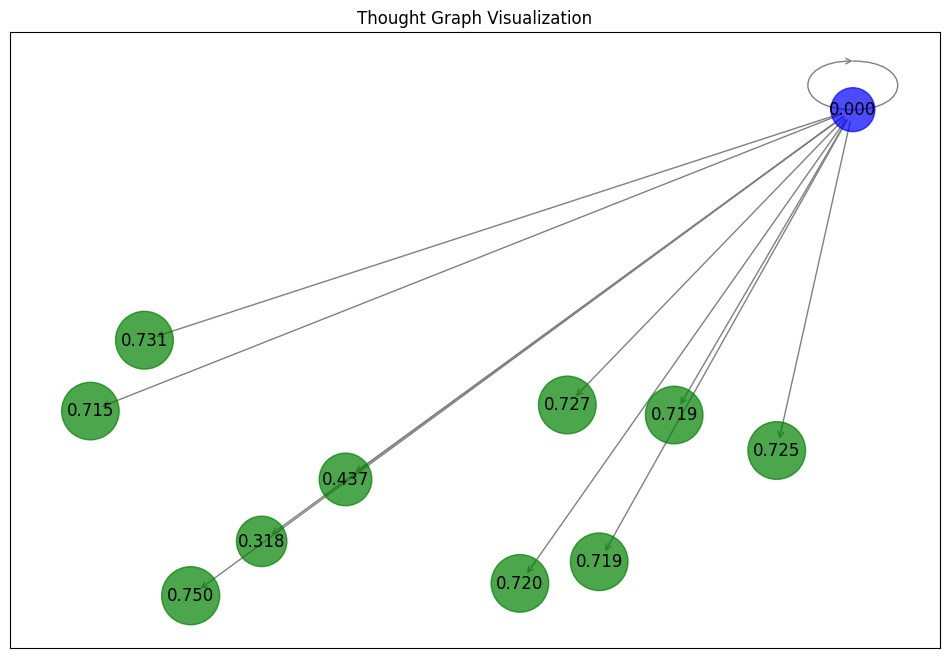

[INFO] === Iteration 2/2 ===


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'include_math' not met, adding gradient: Добавьте математические формулы для лучшего объяснения.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'clarity_and_conciseness' not met, adding gradient: Обеспечьте ясность и краткость в объяснениях.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'clarity_and_conciseness' not met, adding gradient: Обеспечьте ясность и краткость в объяснениях.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Criterion 'clarity_and_conciseness' not met, adding gradient: Следите за ясностью и краткостью в объяснениях.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] Evaluating candidates...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = False, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.32432432432432434, 'p': 0.35294117647058826, 'f': 0.3380281640230114}, 'rouge-2': {'r': 0.21212121212121213, 'p': 0.23529411764705882, 'f': 0.22310756473452814}, 'rouge-l': {'r': 0.3063063063063063, 'p': 0.3333333333333333, 'f': 0.3192488213000067}}
[INFO] BLEU score: 27.182179225185944
[INFO] Total score for the response: 0.31821412271037325 / 1.6 (Normalized: 0.19888382669398327)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = False, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.25225225225225223, 'p': 0.27184466019417475, 'f': 0.2616822379976418}, 'rouge-2': {'r': 0.10606060606060606, 'p': 0.1111111111111111, 'f': 0.10852712678565013}, 'rouge-l': {'r': 0.23423423423423423, 'p': 0.2524271844660194, 'f': 0.24299064921259508}}
[INFO] BLEU score: 22.369296106488232
[INFO] Total score for the response: 0.8933367220554955 / 1.6 (Normalized: 0.5583354512846846)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.2972972972972973, 'p': 0.3235294117647059, 'f': 0.30985914993850433}, 'rouge-2': {'r': 0.16666666666666666, 'p': 0.176, 'f': 0.17120622068464333}, 'rouge-l': {'r': 0.2882882882882883, 'p': 0.3137254901960784, 'f': 0.30046947857700196}}
[INFO] BLEU score: 25.161282853983966
[INFO] Total score for the response: 0.9104164614233683 / 1.6 (Normalized: 0.5690102883896051)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.18018018018018017, 'p': 0.18181818181818182, 'f': 0.1809954701132247}, 'rouge-2': {'r': 0.08333333333333333, 'p': 0.08461538461538462, 'f': 0.08396946064914662}, 'rouge-l': {'r': 0.18018018018018017, 'p': 0.18181818181818182, 'f': 0.1809954701132247}}
[INFO] BLEU score: 20.19590314460771
[INFO] Total score for the response: 0.8765909003118605 / 1.6 (Normalized: 0.5478693126949128)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = False, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.27927927927927926, 'p': 0.3163265306122449, 'f': 0.2966507127226941}, 'rouge-2': {'r': 0.15151515151515152, 'p': 0.17857142857142858, 'f': 0.16393442126310145}, 'rouge-l': {'r': 0.26126126126126126, 'p': 0.29591836734693877, 'f': 0.2775119567418329}}
[INFO] BLEU score: 22.583982167583933
[INFO] Total score for the response: 0.3006703556835345 / 1.6 (Normalized: 0.18791897230220905)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.4774774774774775, 'p': 0.2663316582914573, 'f': 0.3419354792738814}, 'rouge-2': {'r': 0.22727272727272727, 'p': 0.12096774193548387, 'f': 0.15789473230803336}, 'rouge-l': {'r': 0.4594594594594595, 'p': 0.2562814070351759, 'f': 0.32903225346742976}}
[INFO] BLEU score: 28.333100001589923
[INFO] Total score for the response: 0.9224726506966658 / 1.6 (Normalized: 0.5765454066854161)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.5675675675675675, 'p': 0.2971698113207547, 'f': 0.3900928747458521}, 'rouge-2': {'r': 0.30303030303030304, 'p': 0.13157894736842105, 'f': 0.18348623431024333}, 'rouge-l': {'r': 0.5495495495495496, 'p': 0.28773584905660377, 'f': 0.37770897381705953}}
[INFO] BLEU score: 22.90743658782158
[INFO] Total score for the response: 1.321356667939055 / 1.6 (Normalized: 0.8258479174619093)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.4774774774774775, 'p': 0.22844827586206898, 'f': 0.30903789649686786}, 'rouge-2': {'r': 0.25, 'p': 0.09763313609467456, 'f': 0.14042552787541887}, 'rouge-l': {'r': 0.4774774774774775, 'p': 0.22844827586206898, 'f': 0.30903789649686786}}
[INFO] BLEU score: 16.50339941101545
[INFO] Total score for the response: 0.8948143781214045 / 1.6 (Normalized: 0.5592589863258778)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.6846846846846847, 'p': 0.4470588235294118, 'f': 0.5409252621243399}, 'rouge-2': {'r': 0.4772727272727273, 'p': 0.2775330396475771, 'f': 0.35097492571224626}, 'rouge-l': {'r': 0.6846846846846847, 'p': 0.4470588235294118, 'f': 0.5409252621243399}}
[INFO] BLEU score: 33.60420476744185
[INFO] Total score for the response: 0.9753934619597517 / 1.6 (Normalized: 0.6096209137248448)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = False, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.2072072072072072, 'p': 0.23, 'f': 0.218009473686575}, 'rouge-2': {'r': 0.07575757575757576, 'p': 0.08196721311475409, 'f': 0.07874015248806529}, 'rouge-l': {'r': 0.2072072072072072, 'p': 0.23, 'f': 0.218009473686575}}
[INFO] BLEU score: 21.749258902582287
[INFO] Total score for the response: 0.48710041254247954 / 1.6 (Normalized: 0.3044377578390497)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.6216216216216216, 'p': 0.42592592592592593, 'f': 0.5054945006690014}, 'rouge-2': {'r': 0.4166666666666667, 'p': 0.26066350710900477, 'f': 0.3206997037200487}, 'rouge-l': {'r': 0.6126126126126126, 'p': 0.41975308641975306, 'f': 0.49816849334299396}}
[INFO] BLEU score: 44.00987433255246
[INFO] Total score for the response: 0.9876534473337037 / 1.6 (Normalized: 0.6172834045835648)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = False, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.24324324324324326, 'p': 0.2571428571428571, 'f': 0.2499999950038581}, 'rouge-2': {'r': 0.11363636363636363, 'p': 0.1171875, 'f': 0.11538461038579903}, 'rouge-l': {'r': 0.24324324324324326, 'p': 0.2571428571428571, 'f': 0.2499999950038581}}
[INFO] BLEU score: 21.78395055255121
[INFO] Total score for the response: 0.49356790010587404 / 1.6 (Normalized: 0.30847993756617126)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'include_math': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'latex_formatting': Met = True, Required = True, Weight = 0.3


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'clarity_and_conciseness': Met = False, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'detailed_explanation': Met = True, Required = True, Weight = 0.2


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[DEBUG] Evaluating criterion 'context_relevance': Met = True, Required = True, Weight = 0.2
[INFO] ROUGE scores: {'rouge-1': {'r': 0.2882882882882883, 'p': 0.2689075630252101, 'f': 0.2782608645712666}, 'rouge-2': {'r': 0.12121212121212122, 'p': 0.10457516339869281, 'f': 0.112280696781533}, 'rouge-l': {'r': 0.2882882882882883, 'p': 0.2689075630252101, 'f': 0.2782608645712666}}
[INFO] BLEU score: 23.925672766135907
[INFO] Total score for the response: 0.9035035184465251 / 1.6 (Normalized: 0.5646896990290782)
[INFO] Candidate scores: [0.19888382669398327, 0.5583354512846846, 0.5690102883896051, 0.5478693126949128, 0.18791897230220905, 0.5765454066854161, 0.8258479174619093, 0.5592589863258778, 0.6096209137248448, 0.3044377578390497, 0.6172834045835648, 0.30847993756617126, 0.5646896990290782]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

[INFO] Selecting the best candidate using adaptive UCB...
[DEBUG] Variance of candidate scores: 0.03219652247684187, Adaptive Factor: 1.0316890776867467
[DEBUG] UCB values: [0.23108035 1.44946733 1.48413362 1.43900226 1.0478966  1.40605282
 1.6273093  1.33531674 1.36272496 1.03675263 1.33069209 1.00461529
 1.24497035]
[INFO] Selected best candidate index: 6
[INFO] Best prompt at iteration 2: ### Шаг 1: Изучение запроса и понимание требований

Пользователь хочет оптимизировать текущий промпт для ИИ-помощника, который запрашивает представление формулы Ньютона-Лейбница, ее краткое объяснение и контекст использования. Основные требования включают:
1. Формат LaTeX для формулы.
2. Краткое объяснение теоремы.
3. Описание контекста применения.
4. Четкая структура ответа.

### Шаг 2: Упрощение и улучшение промпта

Для улучшения обработки и восприятия информации пользователем, необходимо оптимизировать ясность, краткость и структуру. Текущий промпт уже достаточно структурирован, но можно уточнит

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


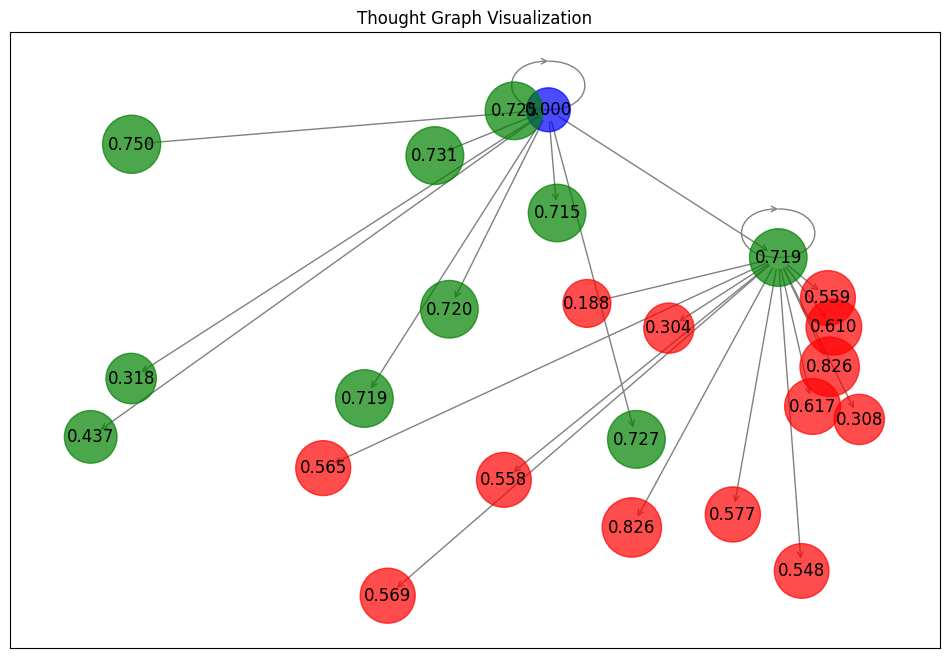

Оптимизированный промпт: ### Оптимизированный промпт:

**Задача:**  
Представьте формулу Ньютона-Лейбница в формате LaTeX и дайте ее краткое объяснение.

**Требования к ответу:**
1. **Формула:**  
   Укажите формулу Ньютона-Лейбница в формате LaTeX.
   
2. **Объяснение теоремы:**  
   Предоставьте краткое описание теоремы, указывая на её связь между интегралами и производными и поясните её значение.

3. **Контекст применения:**  
   Укажите области математики и физики, где применяется эта формула. Приведите конкретные примеры использования.

**Пример формата ответа:**
```latex
1. Формула: 
\[
F(a, b) = \int_{a}^{b} f(x) \, dx
\]

2. Объяснение:
Теорема Ньютона-Лейбница утверждает, что она связывает интегралы и производные, позволяя вычислять площадь под кривой...

3. Контекст:
Формула применяется в математическом анализе для нахождения определенных интегралов и в физике для вычисления работы.
```

**Цель:**  
Получить структурированный и понятный ответ о формуле Ньютона-Лейбница и её з

In [16]:
# Запуск пайплайна
optimizer, optimized_prompt = run_pipeline()

In [17]:
optimizer.thought_graph.get_paths()


[(['\n    Во время твоего ответа, тебе требуется оформлять формулы в формате LaTeX. Напиши формулу Ньютона-Лейбница.\n    ',
   '### Улучшенный промпт:\n\n**Задача:**  \nВо время твоего ответа представь формулы в формате LaTeX. Укажи формулу Ньютона-Лейбница.\n\n**Требования к ответу:**\n1. **Представление формулы:**  \n   - Укажите формулу Ньютона-Лейбница в формате LaTeX.\n   \n2. **Краткое объяснение:**  \n   - Приведите краткое объяснение теоремы Ньютона-Лейбница и её применения в математике.\n\n3. **Контекст использования:**  \n   - Опишите, в каком контексте будет использоваться эта формула (например, в рамках учебного материала по математическому анализу или научной работы).\n\n4. **Структура ответа:**  \n   - Используйте четкие разделы в ответе для каждой из вышеуказанных частей (формула, объяснение, контекст).\n\n**Пример формата ответа:**\n```latex\n1. Формула: \n\\[\nF(a, b) = \\int_{a}^{b} f(x) \\, dx\n\\]\n\n2. Объяснение:\nФормула Ньютона-Лейбница связывает производную и 

In [18]:
optimizer.thought_graph.node_info


{'\n    Во время твоего ответа, тебе требуется оформлять формулы в формате LaTeX. Напиши формулу Ньютона-Лейбница.\n    ': {'quality': 0,
  'usage_count': 0,
  'context': 'Initial prompt',
  'parent': None,
  'response': '',
  'iteration': 0},
 'Во время твоего ответа необходимо использовать формат LaTeX для оформления формул. Укажи формулу Ньютона-Лейбница.': {'quality': 0.7195619421351636,
  'usage_count': 0,
  'context': 'Candidate in iteration 1',
  'parent': '\n    Во время твоего ответа, тебе требуется оформлять формулы в формате LaTeX. Напиши формулу Ньютона-Лейбница.\n    ',
  'response': "Формула Ньютона-Лейбница соединяет дифференциальное и интегральное исчисление. Она утверждает, что если \\( f \\) является непрерывной функцией на отрезке \\([a, b]\\), и \\( F \\) — её первообразной (то есть \\( F'(x) = f(x) \\) для всех \\( x \\) в \\([a, b]\\)), то выполняется следующее равенство:\n\n\\[\n\\int_{a}^{b} f(x) \\, dx = F(b) - F(a)\n\\]\n\nЭта формула позволяет вычислить опред